In [64]:
from __future__ import annotations

import operator
import json

from collections import defaultdict
from functools import partial
from pathlib import Path
from matplotlib import pyplot as plt
from prettyprinter import pprint
from typing import Union, Callable
from itertools import repeat

In [65]:
def load_json(path: Path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

def nested_defaultdict(default_factory: Callable, depth: int = 1):
    """Creates a nested default dictionary of arbitrary depth with a specified callable as leaf."""
    if not depth:
        return default_factory()
    result = partial(defaultdict, default_factory)
    for _ in repeat(None, depth - 1):
        result = partial(defaultdict, result)
    return result()

# def metric_subsets(subset_names: list[str]) -> dict[str, list]:
#     """Returns a container for storing metric values measured for different subsets."""
#     return {subset: [] for subset in subset_names}
    

# def metrics_dict(metric_names: list[str]) -> dict:
#     """Returns a container for storing metrics data for a given model."""
#     return {m: metric_subsets() for m in metric_names}

def metrics_dict(depth: int = 2) -> dict:
    """Returns a container for storing metrics data for a given model."""
    return nested_defaultdict(list, depth=2)


def metrics_dict_transpose() -> defaultdict:
    return nested_defaultdict(list, depth=2)


def parse_log(fpath: Path) -> dict[str, list[float]]:
    
    with open(fpath, 'r') as f:
        lines = f.readlines()
        
    raw_data = defaultdict(list)
    for line in lines:
        if 'Batch' not in line:
            continue
        comps  = line.strip().split('|')
        batch = int(comps[1].strip().split(" ")[1])
        split, _, val = comps[2].strip().split(" ")
        if 'dev' in split:
            raw_data['dev'].append((batch, float(val)))
        else:
            assert 'train' in split
            raw_data['train'].append((batch, float(val)))
    for split in ['train', 'dev']:
        raw_data[split].sort(key=operator.itemgetter(0))
        
    losses = { key: {'loss': [], 'batch': []} for key in raw_data}
    for key in raw_data:
        losses[key]['batch'] = [el[0] for el in raw_data[key]]
        losses[key]['loss'] = [el[1] for el in raw_data[key]]
        
    return losses



In [66]:
from itertools import zip_longest


def format_plot(ax, plot_format):
    """Helper function that calls the matplotlib API with specified format data."""

    # x,y axis ticks and ticklabels
    if plot_format.get("ticks", {}):
        x_ticks = plot_format["ticks"].get("x", [])
        y_ticks = plot_format["ticks"].get("y", [])
        if x_ticks:
            ax.set_xticks(x_ticks["vals"])
            if "labels" in plot_format["ticks"]["x"]:
                ax.set_xticklabels(plot_format["ticks"]["x"]["labels"])
        if y_ticks:
            ax.set_yticks(y_ticks["vals"])
            if "labels" in plot_format["ticks"]["y"]:
                ax.set_yticklabels(plot_format["ticks"]["y"]["labels"])
    # tick params for x,y axis
    tick_params = plot_format.get("tick_params", {})
    if tick_params:
        for axs_label in tick_params:
            ax.tick_params(axis=axs_label, **tick_params[axs_label])
    # x,y axis labels
    ax.set_ylabel(**plot_format.get("ylabel", {"ylabel": ""}))
    ax.set_xlabel(**plot_format.get("xlabel", {"xlabel": ""}))
    # plot title
    if plot_format.get("title", {}):
        ax.set_title(plot_format["title"].pop("label"), **plot_format["title"])  #
    # legend
    ax.legend(**plot_format.get("legend", {}))
    # x,y limits
    ax.set_ylim(**plot_format.get("ylim", {}))
    ax.set_xlim(**plot_format.get("xlim", {}))
    if plt_format.get('grid', False):
        ax.grid()
    
def plot_lines(x: Union[list, dict], y: dict , plt_format: dict, skip_keys : set[str] = None):
    fig, ax = plt.subplots()

    for idx, (key, fmt) in enumerate(zip_longest(y, plt_format.get('fmt', []), fillvalue=None)):
        if key is None:
            continue
        max_y = max(y[key])
        max_y_idx = y[key].index(max_y)
        if skip_keys:
            if key not in skip_keys:
                if isinstance(x[0], list):
                    print(f"Key: {key}. Max y value of {max_y} attained at {x[idx][max_y_idx]} steps")
                    ax.plot(x[idx], y[key], fmt, label=key)
                else:
                    print(f"Key: {key}. Max y value of {max_y} attained at {x[max_y_idx]} steps")
                    ax.plot(x, y[key], fmt, label=key)
        else:
            if isinstance(x, dict):
                print(f"Key: {key}. Max y value of {max_y} attained at {x[key][max_y_idx]} steps")
                ax.plot(x[key], y[key], fmt, label=key)                    
            elif isinstance(x[0], list):
                print(f"Key: {key}. Max y value of {max_y} attained at {x[idx][max_y_idx]} steps")
                ax.plot(x[idx], y[key], fmt, label=key)
            else:
                print(f"Key: {key}. Max y value of {max_y} attained at {x[max_y_idx]} steps")
                ax.plot(x, y[key], fmt, label=key)
    vline_fmt = plt_format.pop("vline", {})
    if vline_fmt:
        x_pos = vline_fmt.pop("x", [])
        for i, x in enumerate(x_pos):
            this_line_kwargs = {
                k: vline_fmt[k][i % len(vline_fmt[k])] for k in vline_fmt
            }
            ax.axvline(x, **this_line_kwargs)
    plt.tight_layout()
    format_plot(ax, plt_format)

# Data loading

Define source data paths. Note that these paths obey the following hierarchy:

- `METRICS_SOURCE_DIR`: this is a directory where you keep all the results from all your experiments
- experiment_name (`MODELS`) : this a sub-directory in `METRIC_SOURCE_DIR` where the results of an experiment have been saved. So in my case I may have subdirectories `metrics/d3st/` `metrics/d3st_retrain_adafactor` and so on
- schema_variant: each experiment subdirectory has one or more of `original`, `v1`, `v2`, `v3`, `v4`, `v5` depending on which splits from which SGD variant has been decoded. We can only load data for one schema variant at a time.
- `SPLITS_EVALUATED`: we may have decoded both `dev` and `test` sets. These will appear as subdirectories in each schema variant
- `MODEL_INPUT_DATA_VERSION` : in each `metrics/<experiment>/<schema_variant>/<split>` directory we have `version_*` subdirectories which contain decoding results from models trained with different data formats (e.g., different input/output linearizations). We can only load only one data version at a time.

**EXAMPLE** ``/scratches/neuron/dev/d3st/metrics/d3st/original/test/version_1`` contains the results of the experiment entitled `d3st`, when decoded on `original` SGD test dataset. The model has been trained with data version `1`. 

In the directory, we find multiple files with the format `model_[step]_metrics.json` where step is a number indicating the training step. The file name is important as it is used to extract the `x-axis` of the plots.

**NOTES**: 
 - It is assumed assumed that your `METRICS_SOURCE_DIR` is in the directory above this notebook.
 - If your hierarchy does not obey the description above, try make it so because it's neat. If you can't be asked set various missing subdirectories to `''` and that particular level of the hierarchy will be ignored (e.g., set `SCHEMA_VARIANT=''` or `MODEL_INPUT_DATA_VERSION=''` if you only cared about SGD and did not version your input data ...). HOWEVER, `SPLITS_EVALUATED` and `MODELS` ought to be set.

In [41]:
METRICS_SOURCE_DIR = 'metrics'
MODEL_INPUT_DATA_VERSION = 'version_3'
MODELS = ['d3st_retrain', 'd3st_retrain_adafactor', 'd3st_retrain_adafactor_constant_lr', 'd3st']
SCHEMA_VARIANT = 'original'
SPLITS_EVALUATED = ['test', 'dev_small']
SERVICE_CATEGORIES = ['#ALL_SERVICES', '#SEEN_SERVICES', '#UNSEEN_SERVICES']
FIRST_MODEL = 'd3st_retrain'
basic_metrics = [
        'joint_goal_accuracy', 
        'joint_cat_accuracy', 
        'joint_noncat_accuracy'
    ]
METRICS = {
    m: basic_metrics for m in MODELS
}

In [42]:
metric_paths = nested_defaultdict(list, depth=2)
sorted_metric_paths = nested_defaultdict(list, depth=2)
for model in MODELS:
    for split in SPLITS_EVALUATED:
        metric_paths[model][split] = list(Path('..').resolve().joinpath(METRICS_SOURCE_DIR, model, SCHEMA_VARIANT, split, MODEL_INPUT_DATA_VERSION).glob("*_metrics.json"))
        sorted_metric_paths[model][split] = sorted(metric_paths[model][split], key= lambda fpath: int(fpath.name.split("_")[1]))
    

Load the raw data and process it into time series that fit the plotting API design.

In [43]:
metrics_by_model = nested_defaultdict(dict, depth=2)
metrics_by_model_transpose = nested_defaultdict(dict, depth=2)

for model in MODELS:
    for split in SPLITS_EVALUATED:
        this_model_metrics = metrics_dict()
        this_model_metrics_transpose = metrics_dict_transpose()
        for path in sorted_metric_paths[model][split]:
            this_step_metrics = load_json(path)
            for metric in METRICS[model]:
                for service_type in SERVICE_CATEGORIES:
                    this_model_metrics[metric][service_type].append(this_step_metrics[service_type][metric])
                    this_model_metrics_transpose[service_type][metric].append(this_step_metrics[service_type][metric])
        metrics_by_model[model][split] = this_model_metrics
        metrics_by_model_transpose[model][split] = this_model_metrics_transpose

Extract the training step from the name of the files output by the Google SGD evaluation script.

In [44]:
steps = nested_defaultdict(list, depth=2)
steps_transposed = nested_defaultdict(list, depth=2)
for model in MODELS:
    for split in SPLITS_EVALUATED:
        steps[model][split] = sorted([int(fpath.name.split("_")[1]) for fpath in metric_paths[model][split]])

# Analyse individual model performance

Change ``model`` variable  to a member of `MODELS` to view graphs.

In [26]:
model = 'd3st_retrain_adafactor_constant_lr'
split = 'test'
assert split in SPLITS_EVALUATED

The `plt_format` is just a hierarchical `dict` which contains `matplotlib` `ax` functions as keys and arguments to those APIs as values. As a result, it is easy to make the plot look pretty in a flash and we don't need 100s of lines of code.

Plotting metric joint_goal_accuracy
Key: #ALL_SERVICES. Max y value of 0.7098771903460838 attained at 840000 steps
Key: #SEEN_SERVICES. Max y value of 0.9327315134760378 attained at 960000 steps
Key: #UNSEEN_SERVICES. Max y value of 0.636652824999277 attained at 840000 steps
Plotting metric joint_cat_accuracy
Key: #ALL_SERVICES. Max y value of 0.8598025048169556 attained at 800000 steps
Key: #SEEN_SERVICES. Max y value of 0.9696096931174893 attained at 520000 steps
Key: #UNSEEN_SERVICES. Max y value of 0.8248704333725477 attained at 800000 steps
Plotting metric joint_noncat_accuracy
Key: #ALL_SERVICES. Max y value of 0.80721581225605 attained at 840000 steps
Key: #SEEN_SERVICES. Max y value of 0.9597227231129214 attained at 880000 steps
Key: #UNSEEN_SERVICES. Max y value of 0.7572612608959712 attained at 840000 steps


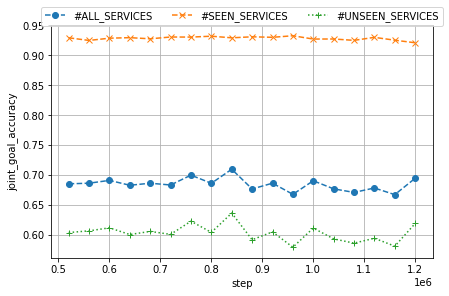

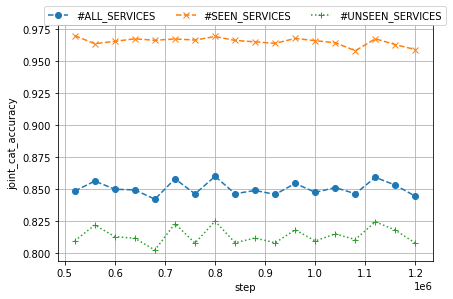

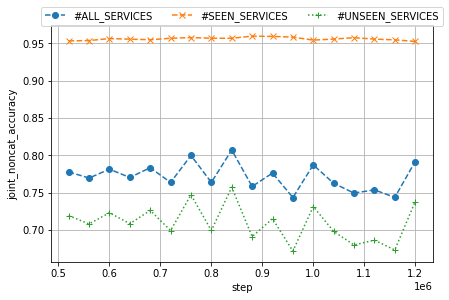

In [27]:
for metric in METRICS[model]:
    print(f"Plotting metric {metric}")
    plt_format = {
        'grid': True,
        "xlabel": {"xlabel": "step", "size": "medium"},
        "ylabel": {"ylabel": metric, "size": "medium"},
        'fmt': ['--o', '--x', ':+'],
        'tick_params':{
            'x': {'labelsize': 'medium'},  # ax.tick_params  API
            'y': {'labelsize': 'medium'}
        },
        'formatter': {
            'y': '{x:,.2f}'
        },
        'legend': {'fontsize': 'medium', 'ncol': 3, 'loc': 'upper center', 'bbox_to_anchor': (0.5,1.10)},  # ax.legend API

    }
    plot_lines(steps[model][split], metrics_by_model[model][split][metric], plt_format)

Plotting metric joint_goal_accuracy
Key: #ALL_SERVICES. Max y value of 0.7098771903460838 attained at 840000 steps
Key: #SEEN_SERVICES. Max y value of 0.9327315134760378 attained at 960000 steps
Key: #UNSEEN_SERVICES. Max y value of 0.636652824999277 attained at 840000 steps
Plotting metric joint_cat_accuracy
Key: #ALL_SERVICES. Max y value of 0.8598025048169556 attained at 800000 steps
Key: #SEEN_SERVICES. Max y value of 0.9696096931174893 attained at 520000 steps
Key: #UNSEEN_SERVICES. Max y value of 0.8248704333725477 attained at 800000 steps
Plotting metric joint_noncat_accuracy
Key: #ALL_SERVICES. Max y value of 0.80721581225605 attained at 840000 steps
Key: #SEEN_SERVICES. Max y value of 0.9597227231129214 attained at 880000 steps
Key: #UNSEEN_SERVICES. Max y value of 0.7572612608959712 attained at 840000 steps


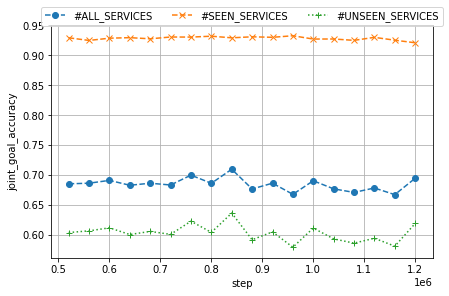

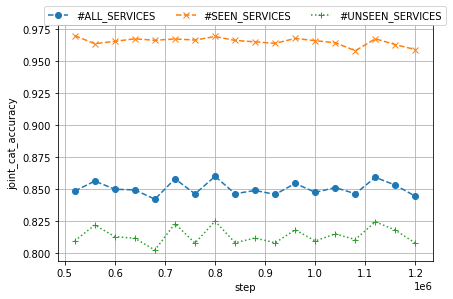

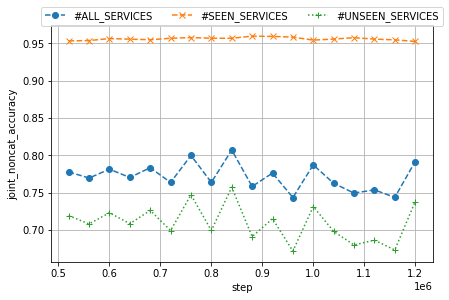

In [28]:
for metric in METRICS[model]:
    print(f"Plotting metric {metric}")
    plt_format = {
        'grid': True,
        "xlabel": {"xlabel": "step", "size": "medium"},
        "ylabel": {"ylabel": metric, "size": "medium"},
        'fmt': ['--o', '--x', ':+'],
        'tick_params':{
            'x': {'labelsize': 'medium'},  # ax.tick_params  API
            'y': {'labelsize': 'medium'}
        },
        'formatter': {
            'y': '{x:,.2f}'
        },
        'legend': {'fontsize': 'medium', 'ncol': 3, 'loc': 'upper center', 'bbox_to_anchor': (0.5,1.10)},  # ax.legend API

    }

    plot_lines(steps[model][split], metrics_by_model[model][split][metric], plt_format)

Look at model performance on unsseen services, for each metric.

Plotting metric joint_goal_accuracy
Key: #UNSEEN_SERVICES. Max y value of 0.8406456590509666 attained at 1560000 steps
Plotting metric joint_cat_accuracy
Key: #UNSEEN_SERVICES. Max y value of 0.9462285287528006 attained at 1560000 steps
Plotting metric joint_noncat_accuracy
Key: #UNSEEN_SERVICES. Max y value of 0.8834917750439367 attained at 1560000 steps


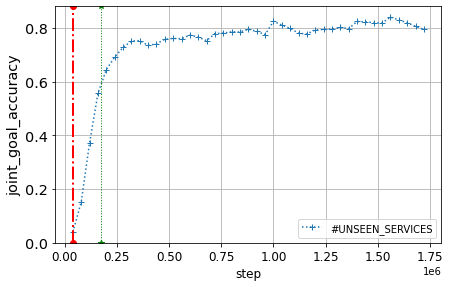

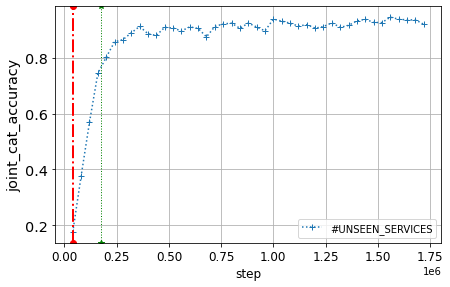

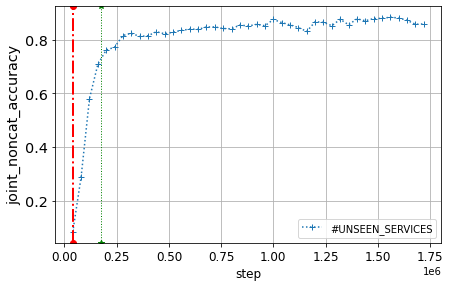

In [11]:
for metric in METRICS[model]:
    print(f"Plotting metric {metric}")
    plt_format = {
        'grid': True,
        "xlabel": {"xlabel": "step", "size": "large"},
        "ylabel": {"ylabel": metric, "size": "x-large"},
        'fmt': ['--o', '--x', ':+'],
        'tick_params':{
            'x': {'labelsize': 'large'},  # ax.tick_params  API
            'y': {'labelsize': 'x-large'}
        },
        'formatter': {
            'y': '{x:,.5f}'
        },
        'vline': {
            'x': [40000, 175850],
            'linestyle': ["-.",":"],
            'linewidth': [2.0, 1.0],
            'mec': ['r', 'g'],
            'marker': ['o', '*'],
            'markevery': [0.2, 0.25],
            'color': ['r', 'g']
            
        }

    }

    plot_lines(steps[model][split], metrics_by_model[model][split][metric], plt_format, skip_keys={'#ALL_SERVICES', '#SEEN_SERVICES'})

Look at model performance on seen services, for each metric.

Plotting metric: joint_goal_accuracy
Key: #SEEN_SERVICES. Max y value of 0.9478688318777292 attained at 1720000 steps
Plotting metric: joint_cat_accuracy
Key: #SEEN_SERVICES. Max y value of 0.9849201655824955 attained at 1600000 steps
Plotting metric: joint_noncat_accuracy
Key: #SEEN_SERVICES. Max y value of 0.9636391157205241 attained at 1160000 steps


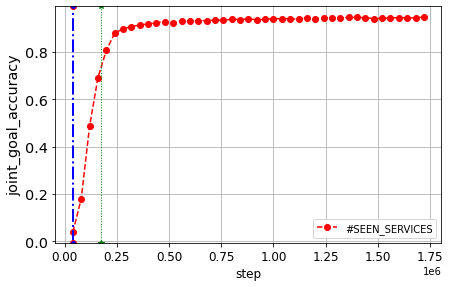

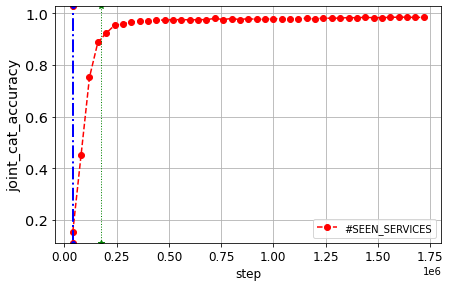

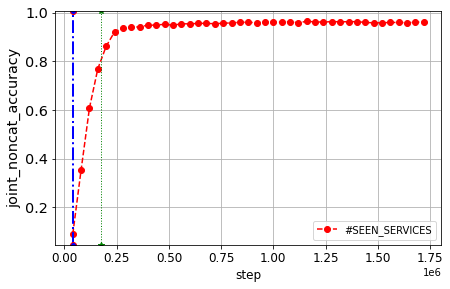

In [12]:
for metric in METRICS[model]:
    print(f"Plotting metric: {metric}")
    plt_format = {
        'grid': True,
        "xlabel": {"xlabel": "step", "size": "large"},
        "ylabel": {"ylabel": metric, "size": "x-large"},
        'fmt': ['--x','--or', ':+'],
        'tick_params':{
            'x': {'labelsize': 'large'},  # ax.tick_params  API
            'y': {'labelsize': 'x-large'}
        },
        'formatter': {
            'y': '{x:,.5f}'
        },
        'vline': {
            'x': [40000, 175850],
            'linestyle': ["-.",":"],
            'linewidth': [2.0, 1.0],
            'mec': ['r', 'g'],
            'marker': ['o', '*'],
            'markevery': [0.2, 0.25],
            'color': ['b', 'g']
            
        }

    }

    plot_lines(steps[model][split], metrics_by_model[model][split][metric], plt_format, skip_keys={'#ALL_SERVICES', '#UNSEEN_SERVICES'})

Look at model performance on all services, for each metric.

Plotting metric joint_goal_accuracy
Key: #ALL_SERVICES. Max y value of 0.8992538024274083 attained at 1560000 steps
Plotting metric joint_cat_accuracy
Key: #ALL_SERVICES. Max y value of 0.9673267326732673 attained at 1560000 steps
Plotting metric joint_noncat_accuracy
Key: #ALL_SERVICES. Max y value of 0.9261576586265171 attained at 1560000 steps


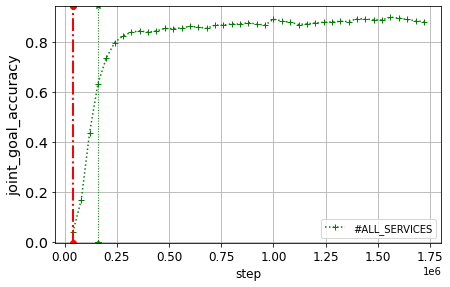

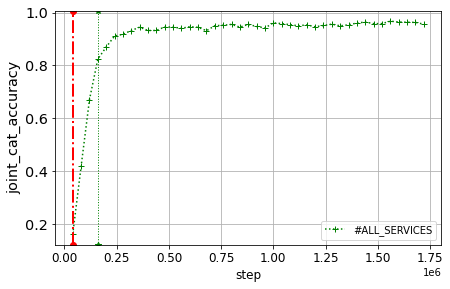

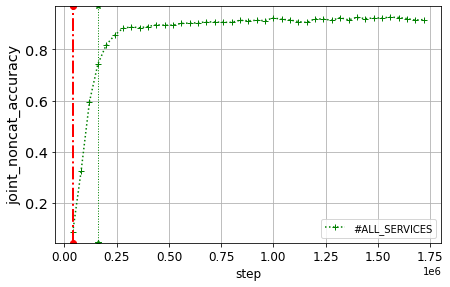

In [13]:
for metric in METRICS[model]:
    print(f"Plotting metric {metric}")
    plt_format = {
        'grid': True,
        "xlabel": {"xlabel": "step", "size": "large"},
        "ylabel": {"ylabel": metric, "size": "x-large"},
        'fmt': [ ':+g'],
        'tick_params':{
            'x': {'labelsize': 'large'},  # ax.tick_params  API
            'y': {'labelsize': 'x-large'}
        },
        'formatter': {
            'y': '{x:,.5f}'
        },
        'vline': {
            'x': [40000, 160000],
            'linestyle': ["-.",":"],
            'linewidth': [2.0, 1.0],
            'mec': ['r', 'g'],
            'marker': ['o', '*'],
            'markevery': [0.2, 0.25],
            'color': ['r', 'g']
            
        }

    }
    plot_lines(steps[model][split],  metrics_by_model[model][split][metric], plt_format, skip_keys={'#SEEN_SERVICES', '#UNSEEN_SERVICES'})

For a given model and service category, plot the change in metrics over time across different subsamples of the same dataset.

In [14]:
print(SERVICE_CATEGORIES)

['#ALL_SERVICES', '#SEEN_SERVICES', '#UNSEEN_SERVICES']


In [15]:
metrics_by_model['d3st_retrain'].keys()

dict_keys(['test', 'dev_small'])

In [24]:
# Individual metrics 
splits_compared = ['dev_small', 'test']
model_selected = 'd3st_retrain_adafactor_constant_lr'
service_category = '#UNSEEN_SERVICES'

Plotting metric joint_goal_accuracy
Key: dev_small. Max y value of 0.8406456590509666 attained at 1560000 steps
Key: test. Max y value of 0.636652824999277 attained at 840000 steps
Plotting metric joint_cat_accuracy
Key: dev_small. Max y value of 0.9462285287528006 attained at 1560000 steps
Key: test. Max y value of 0.8248704333725477 attained at 800000 steps
Plotting metric joint_noncat_accuracy
Key: dev_small. Max y value of 0.8834917750439367 attained at 1560000 steps
Key: test. Max y value of 0.7572612608959712 attained at 840000 steps


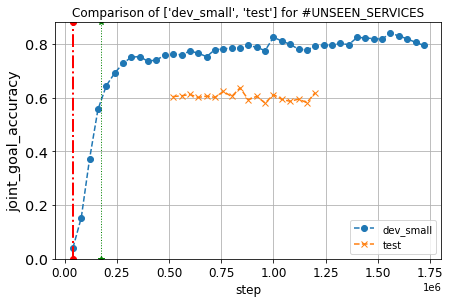

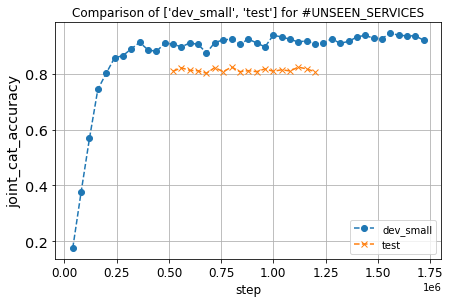

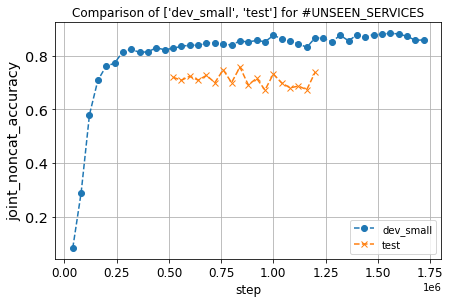

In [25]:
plt_format = {
    'grid': True,
    "xlabel": {"xlabel": "step", "size": "large"},
    "ylabel": {"ylabel": metric, "size": "x-large"},
    'fmt': ['--o', '--x', ':+'],
    'tick_params':{
        'x': {'labelsize': 'large'},  # ax.tick_params  API
        'y': {'labelsize': 'x-large'}
    },
    'formatter': {
        'y': '{x:,.5f}'
    },
    'vline': {
        'x': [40000, 175850],
        'linestyle': ["-.",":"],
        'linewidth': [2.0, 1.0],
        'mec': ['r', 'g'],
        'marker': ['o', '*'],
        'markevery': [0.2, 0.25],
        'color': ['r', 'g']
    },
    'title': {
       'label': ''
    },

}
for metric in METRICS[model_selected]:
    print(f"Plotting metric {metric}")
    series = { 
        comp_split: metrics_by_model[model_selected][comp_split][metric][service_category] for comp_split in splits_compared   
    }
    plt_format['title']['label'] = f'Comparison of {list(series.keys())} for {service_category}'
    plt_format['ylabel']['ylabel'] = metric
    plot_lines(steps[model_selected], series, plt_format=plt_format)

For a given model and evaluation set, compare different metrics across SEEN/UNSEEN/ALL services.

In [62]:
# metrics by service
model_selected = 'd3st_retrain_adafactor_constant_lr'
evaluation_split = 'test'

Plotting metric joint_noncat_accuracy
Key: joint_goal_accuracy. Max y value of 0.7098771903460838 attained at 840000 steps
Key: joint_cat_accuracy. Max y value of 0.8598025048169556 attained at 800000 steps
Key: joint_noncat_accuracy. Max y value of 0.80721581225605 attained at 840000 steps
Plotting metric joint_noncat_accuracy
Key: joint_goal_accuracy. Max y value of 0.9327315134760378 attained at 960000 steps
Key: joint_cat_accuracy. Max y value of 0.9696096931174893 attained at 520000 steps
Key: joint_noncat_accuracy. Max y value of 0.9597227231129214 attained at 880000 steps
Plotting metric joint_noncat_accuracy
Key: joint_goal_accuracy. Max y value of 0.636652824999277 attained at 840000 steps
Key: joint_cat_accuracy. Max y value of 0.8248704333725477 attained at 800000 steps
Key: joint_noncat_accuracy. Max y value of 0.7572612608959712 attained at 840000 steps


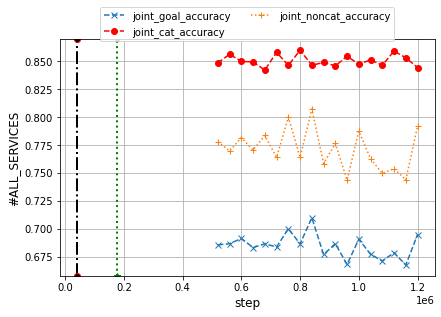

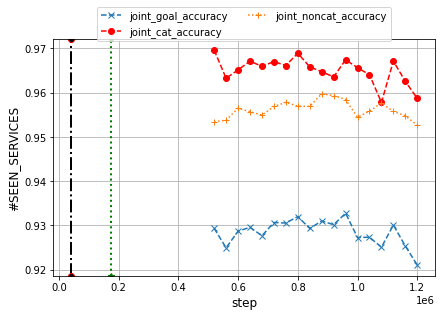

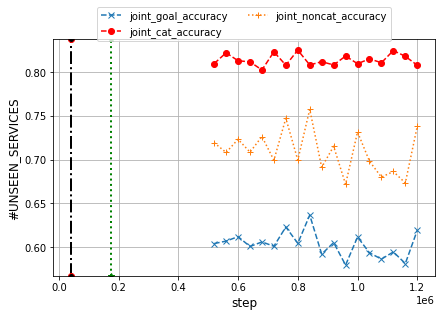

In [63]:
for service_cat in SERVICE_CATEGORIES:
    print(f"Plotting metric {metric}")
    plt_format = {
        'grid': True,
        "xlabel": {"xlabel": "step", "size": "large"},
        "ylabel": {"ylabel": service_cat, "size": "large"},
        'fmt': ['--x','--or', ':+', '-.p'],
        'tick_params':{
            'x': {'labelsize': 'medium'},  # ax.tick_params  API
            'y': {'labelsize': 'medium'}
        },
        'formatter': {
            'y': '{x:,.5f}'
        },
        'legend': {'fontsize': 'medium', 'ncol': 2, 'loc': 'upper center', 'bbox_to_anchor': (0.5,1.16)},  # ax.legend API
        'vline': {
            'x': [40000, 175850],
            'linestyle': ["-.",":"],
            'linewidth': [2.0, 2.0],
            'mec': ['r', 'g'],
            'marker': ['o', '*'],
            'markevery': [0.2, 0.25],
            'color': ['k', 'g']
            
        }


    }

    plot_lines(steps[model_selected][evaluation_split], metrics_by_model_transpose[model_selected][evaluation_split][service_cat], plt_format)

# Compare models task-oriented performance

Compare task-oriented models performance on a given evaluation dataset.

In [23]:
MODELS

['d3st_retrain',
 'd3st_retrain_adafactor',
 'd3st_retrain_adafactor_constant_lr',
 'd3st']

In [48]:
evaluation_dataset = 'test'
models_compared = MODELS[:-1]

In [49]:
models_compared

['d3st_retrain',
 'd3st_retrain_adafactor',
 'd3st_retrain_adafactor_constant_lr']

Note how the `plt_format` can be used to control the `x` and `y` limits to `zoom in` on different parts of the curve. 

In [56]:
markers = ['--x','--or', ':+', '-.p', ':3']
plt_format = {
    'grid': True,
    "xlabel": {"xlabel": "step", "size": "large"},
    "ylabel": {"ylabel": 'loss', "size": "large"},
    'fmt': markers[:len(models_compared)],
    'tick_params':{
        'x': {'labelsize': 'large', 'rotation': 45},  # ax.tick_params  API
        'y': {'labelsize': 'large'}
    },
    'formatter': {
        'y': '{x:,.5f}'
    },
    'title': {
       'label': ''
    },
    'legend': {'fontsize': 'medium', 'ncol': 3, 'loc': 'upper center', 'bbox_to_anchor': (0.5,1.275)},  # ax.legend API
    'xlim': {'left': 500000},
    'ylim': {'bottom': 0.55}

}

Plotting service type #ALL_SERVICES
Plotting metric joint_goal_accuracy
Key: d3st_retrain. Max y value of 0.7103186476710904 attained at 1000000 steps
Key: d3st_retrain_adafactor. Max y value of 0.7049554813947437 attained at 1200000 steps
Key: d3st_retrain_adafactor_constant_lr. Max y value of 0.7098771903460838 attained at 840000 steps
Plotting metric joint_cat_accuracy
Key: d3st_retrain. Max y value of 0.8578034682080925 attained at 1000000 steps
Key: d3st_retrain_adafactor. Max y value of 0.8626445086705202 attained at 1600000 steps
Key: d3st_retrain_adafactor_constant_lr. Max y value of 0.8598025048169556 attained at 800000 steps
Plotting metric joint_noncat_accuracy
Key: d3st_retrain. Max y value of 0.8027526594023766 attained at 680000 steps
Key: d3st_retrain_adafactor. Max y value of 0.7962020355191257 attained at 1200000 steps
Key: d3st_retrain_adafactor_constant_lr. Max y value of 0.80721581225605 attained at 840000 steps
Plotting service type #SEEN_SERVICES
Plotting metric j

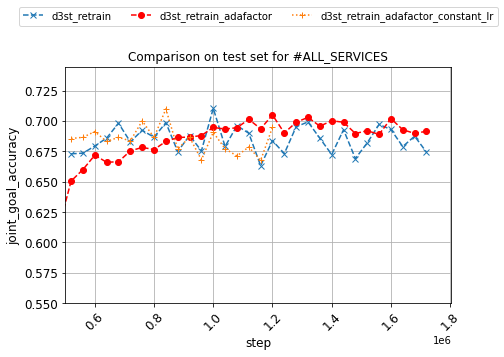

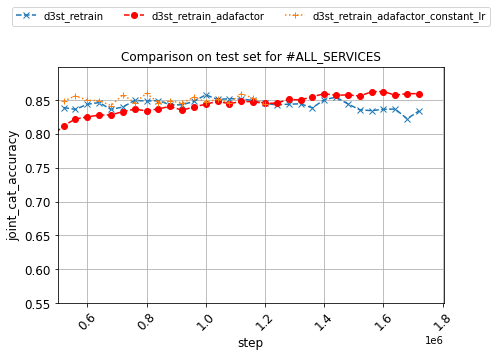

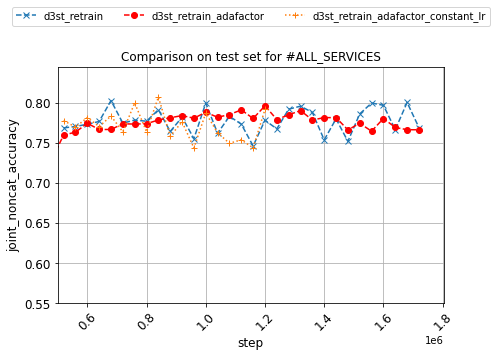

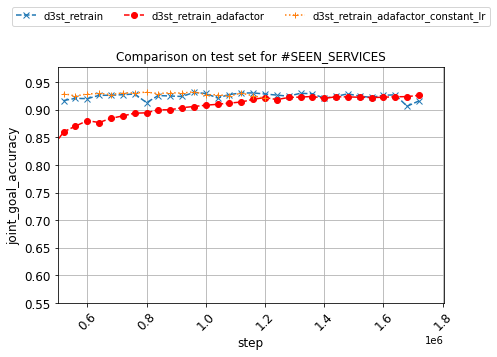

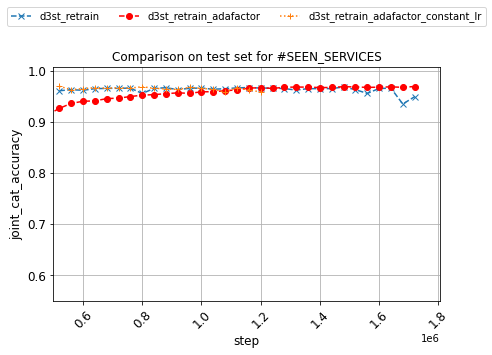

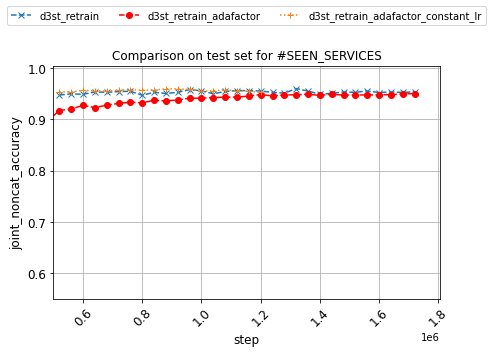

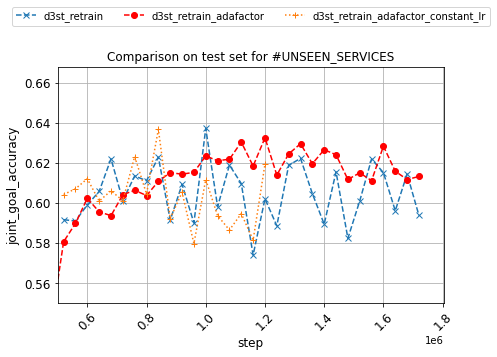

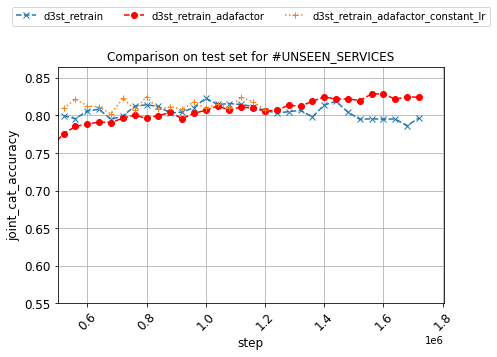

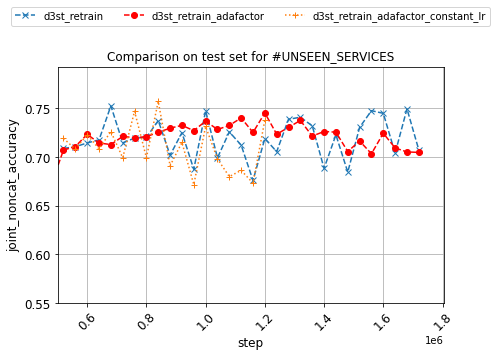

In [57]:
for service_cat in SERVICE_CATEGORIES:
    print(f"Plotting service type {service_cat}")
    for metric in METRICS[FIRST_MODEL]:
        print(f"Plotting metric {metric}")
        series =  {
            model: metrics_by_model[model][evaluation_dataset][metric][service_cat] for model in models_compared
        }
        s = {
            model: steps[model][evaluation_dataset] for model in models_compared
        }
        # plt_format['title']['label'] = f'Comparison of {list(series.keys())} for {service_cat}'
        plt_format['title']['label'] = f'Comparison on {evaluation_dataset} set for {service_cat}'
        plt_format['ylabel']['ylabel'] = metric
        plot_lines(s, series, plt_format=plt_format)